In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os
import sys
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, functional, CenterCrop
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch
from typing import List, Tuple, Any
import numpy as np
from matplotlib import pyplot as plt
import logging
from pickle import dump
from time import time
from math import ceil
from matplotlib.ticker import MaxNLocator

In [25]:
from biomedical_image_segmentation.utils import load_pickle
from biomedical_image_segmentation.losses.loss import MSELoss, BCELoss
from biomedical_image_segmentation.models.custom_unet import CustomUNet
from biomedical_image_segmentation.data.validator import validate
from biomedical_image_segmentation.data.utils import process_output
from biomedical_image_segmentation.utils import create_dir, empty_dir
from biomedical_image_segmentation.plot_utils import plot_results 
from biomedical_image_segmentation.errors import pixel_error, rand_error

In [4]:
PROJECT_PATH = os.getcwd().replace("notebooks","")
LOGS_PATH = os.path.join(PROJECT_PATH, "logs")
DATA_PATH = os.path.join(PROJECT_PATH, "data")
TEST_DATA_PATH = os.path.join(DATA_PATH, "test")

# to save all models
MODELS_PATH = os.path.join(DATA_PATH, "model-weights")

MODEL_NAME = "unet-700-manual-weighted-pixels1"
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME)

METRICS_NAME = f"{MODEL_NAME}-metrics"

SCRIPT_NAME = f"{MODEL_NAME}-model-testing"

LOG_PATH = os.path.join(LOGS_PATH, MODEL_NAME)
LOG_FILE_NAME = os.path.join(LOG_PATH, f"{SCRIPT_NAME}-{int(time())}.log")

VALIDATE_DATA = True

TEST_BATCH_SIZE = 1
DEVICE = "cpu"

In [5]:
create_dir(LOG_PATH, True)

if os.path.basename(LOG_FILE_NAME) in os.listdir(LOG_PATH): os.remove(LOG_FILE_NAME)
    
logging.basicConfig(
    filename=LOG_FILE_NAME,
    format='%(asctime)s %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    encoding='utf-8', 
    level=logging.INFO)

In [6]:
logging.info("Loading test dataset")
test_dataset = load_pickle(os.path.join(TEST_DATA_PATH, "test.pickle"))

In [7]:
if VALIDATE_DATA:
    logging.info("Validating test dataset")
    validate(test_dataset)

In [8]:
logging.info(f"Number of samples in test dataset: {len(test_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

Number of samples in test dataset: 5


In [9]:
NUM_TEST_BATCHES = len(test_dataset) // TEST_BATCH_SIZE + ceil(len(test_dataset) % TEST_BATCH_SIZE)

logging.info(f"Batch size test: {TEST_BATCH_SIZE}")
logging.info(f"Number of batches test: {NUM_TEST_BATCHES}")

In [10]:
class CustomDataset(Dataset):
    def __init__(
      self, 
      dataset: List[Tuple[np.ndarray, np.ndarray]],
      image_transformations=None, 
      mask_transformations=None ):
        self.data = dataset
        self.image_transformations = image_transformations
        self.mask_transformations = mask_transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, mask = self.data[idx]
        if self.image_transformations is not None:
            img = self.image_transformations(img)
            
        if self.mask_transformations is not None:
            mask = self.mask_transformations(mask)

        return img, mask

In [11]:


logging.info("Preparing test data loaders")

test_loader = DataLoader(
    dataset=CustomDataset(
        test_dataset, 
        image_transformations=image_transformations, 
        mask_transformations=mask_transformations), 
    batch_size = TEST_BATCH_SIZE, 
    shuffle = False)

In [12]:
if VALIDATE_DATA:
    logging.info("Validating masks of test dataset")
    for X, Y in tqdm(test_loader, leave=False):
        assert np.allclose(np.unique(Y), np.array([0., 1.]))
    logging.info("Validation of masks passed")

In [13]:
logging.info("Loading model in CPU")
unet = CustomUNet()

In [14]:
# saving at epoch level
metrics = {
    "train": {"loss": [], "pixel-error": []},
    "valid": {"loss": [], "pixel-error": []},
    "min_valid_loss": 1e10}

In [15]:
logging.info("Checking if model already exists")

if MODEL_NAME in os.listdir(MODEL_PATH):
    logging.info(f"{MODEL_NAME} already exists, loading weights")
    unet.load_state_dict(torch.load(os.path.join(MODEL_PATH, MODEL_NAME)))
    metrics = load_pickle(os.path.join(MODEL_PATH, f"{METRICS_NAME}.pickle"))
    logging.info(f"Min valid loss: {metrics['min_valid_loss']}")
else:
    logging.info(f"{MODEL_NAME} does not exists")

In [16]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# logging.info(f"GPU available: {True if device.type == 'cuda' else False}")

# unet.to(device)

In [17]:
logging.info("Loading best model")
unet.load_state_dict(torch.load(os.path.join(MODEL_PATH, MODEL_NAME)))

<All keys matched successfully>

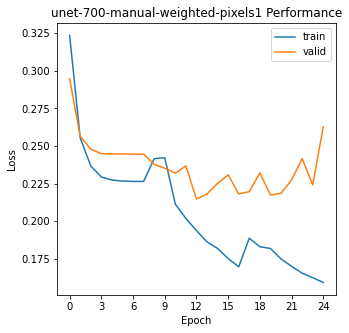

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
for mode in ["train", "valid"]:
    ax.plot(metrics[mode]["loss"], label=mode)
ax.set_title(f"{MODEL_NAME} Performance")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
plt.show()

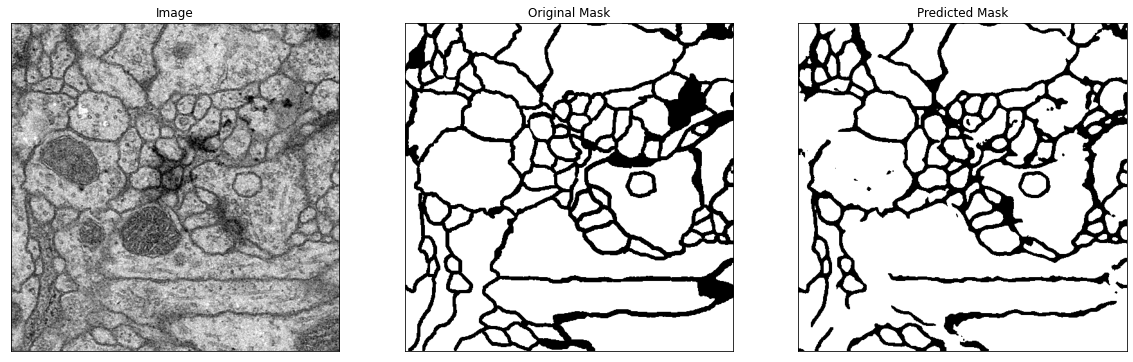

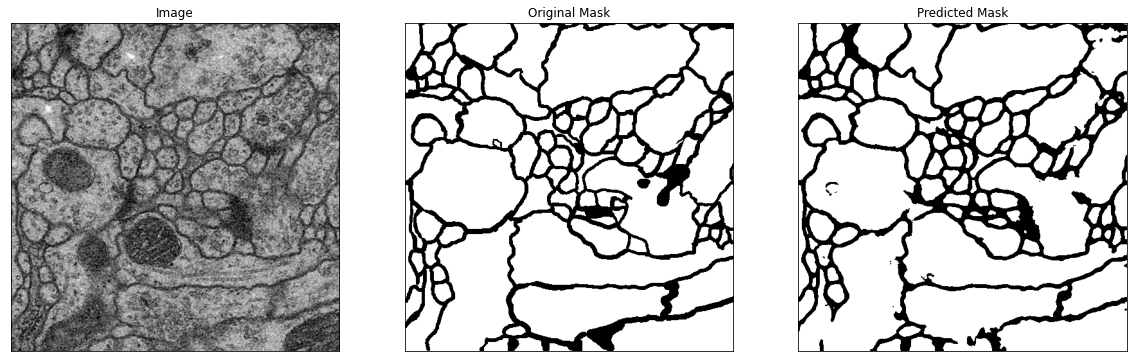

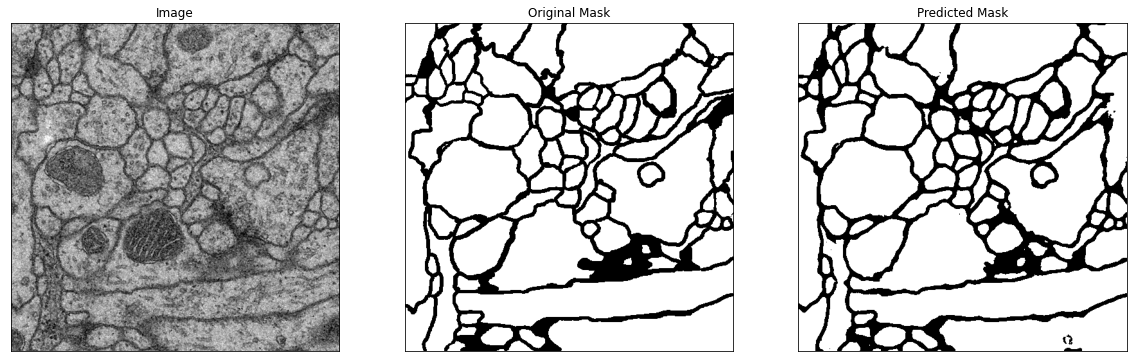

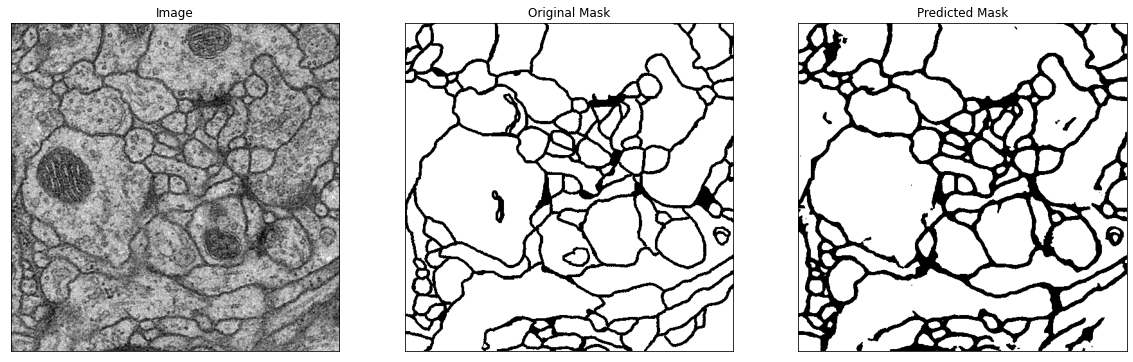

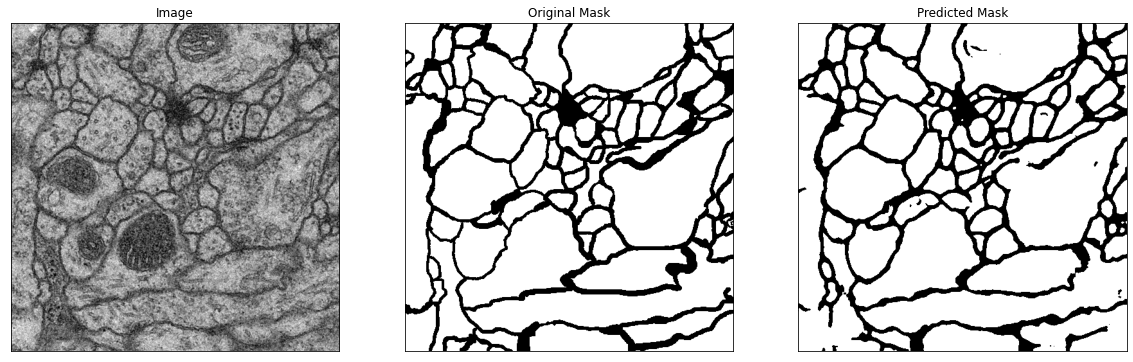

In [19]:
device = "cpu" if DEVICE != "cuda" else DEVICE
unet.to(device)
unet.eval()

mean_pixel_error = []
mean_rand_error = []

for i, (img, mask) in enumerate(test_loader):
    mask = mask.to(device)
    
    output = unet(img.to(device)).detach()
    
    if device=="cuda":
        mask = mask.cpu()
        output = output.detach().cpu()
        
    mean_pixel_error.append(pixel_error(mask[0][0], process_output(output)[0][0]))
    mean_rand_error.append(rand_error(mask[0][0], process_output(output)[0][0]))
    
    plot_results(
        CenterCrop(512)(img)[0][0],
        mask[0][0],
        process_output(output)[0][0])
    
    
    
logging.info(f"{MODEL_NAME}: pixel-errors: {mean_pixel_error}")
logging.info(f"{MODEL_NAME}: mean pixel-error: {np.mean(mean_pixel_error)}")

logging.info(f"{MODEL_NAME}: rand-errors: {mean_rand_error}")
logging.info(f"{MODEL_NAME}: mean rand-error: {np.mean(mean_rand_error)}")

In [21]:
np.mean(mean_pixel_error), np.mean(mean_rand_error)

(0.082826234, 0.15175346334668424)